<a href="https://colab.research.google.com/github/epadam/CNN_AV1/blob/master/training/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os, sys, pickle, json
from os import makedirs
from os.path import exists, join
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [49]:
import urllib.request
#request dataset for 64
urllib.request.urlretrieve('http://download2269.mediafire.com/n3loxvto5yag/txp7zspyh5njd7o/merge_aecf_samples_64_intra_uint8.txt', 'undersampling_pixel_64.txt')
urllib.request.urlretrieve('http://download2268.mediafire.com/pmniu1lnafkg/6uxaiphdd61m10n/merge_aecf_labels_64_intra.txt', 'undersampling_labels_64.txt')
urllib.request.urlretrieve('http://download1525.mediafire.com/xakscozs0qxg/n6y8a8negm2yzhe/merge_aecf_qps_64_intra.txt', 'undersampling_QPs_64.txt')

os.listdir()

['.config',
 'ash_qps_16_intra.txt',
 'undersampling_QPs_64.txt',
 'undersampling_pixel_64.txt',
 'ash_labels_16_intra.txt',
 'ash_qps_32_intra.txt',
 'undersampling_labels_64.txt',
 'sample_data']

In [0]:
batch_size = 128
num_classes = 10
block_size = 64
NUM_CHANNELS = 1
epochs = 50

In [88]:
sample_file = 'undersampling_pixel_64.txt'
label_file = 'undersampling_labels_64.txt'
qp_file = 'undersampling_QPs_64.txt'

with open(sample_file, 'rb') as f:
    pixels = f.read()
    raw = np.frombuffer(pixels, dtype = np.uint8)
    raw = np.reshape(raw, [-1, block_size, block_size, NUM_CHANNELS])
    print(np.shape(raw))
    raw_train = raw[:len(raw)//10*9]
    print(np.shape(raw_train))
    raw_test = raw[-len(raw)//10:]
    print(np.shape(raw_test))


with open(label_file, 'r') as f_single_label:
    single_label = f_single_label.read()    
    single_label =np.fromstring (single_label, dtype=np.uint8 ,sep=' ')
    single_label = np.reshape(single_label, [-1])
    y_test = single_label[-len(raw)//10:]
    single_label = keras.utils.to_categorical(single_label, num_classes)
    #print(np.shape(single_label))
    label_train = single_label[:len(raw)//10*9]
    label_test = single_label[-len(raw)//10:]
    print(np.shape(label_train))
    print(np.shape(label_test))


with open(qp_file, 'r') as f_qp:
    qps = f_qp.read()
    qps =np.fromstring (qps, dtype=np.uint8, sep=' ')
    qps = np.reshape(qps, [-1,1])
    #print(np.shape(qps))
    qp_train = qps[:len(raw)//10*9]
    qp_test = qps[-len(raw)//10:]
    print(np.shape(qp_train))
    print(np.shape(qp_test))


(4550, 64, 64, 1)
(4095, 64, 64, 1)
(455, 64, 64, 1)
(4095, 10)
(455, 10)
(4095, 1)
(455, 1)


In [0]:
# check how the samples look like
image = np.reshape(raw, [-1, block_size, block_size])
for i in range(10):
	print('partition=',single_label[i], 'QP=',qps[i,0])
	plt.imshow(image[i], cmap='gray')
	plt.colorbar()
	plt.show()

In [0]:
from tensorflow.keras import optimizers, backend
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Concatenate, Conv2D, MaxPooling2D, Lambda, BatchNormalization, AveragePooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

In [0]:
def sub_mean(x):
    x = x/255
    x = x - backend.mean(x)   
    return x


def m1_64():

    data = Input(shape=(block_size,block_size,NUM_CHANNELS))

    data_norm = Lambda(sub_mean)(data)

    data_pooling = AveragePooling2D(pool_size=(4, 4),padding='valid')(data_norm)

    conv1 = Conv2D(16, (4, 4), strides =(4,4), activation='relu', padding='valid')(data_pooling)
    conv1_d = Dropout(0.5)(conv1)

    conv2 = Conv2D(24, (2, 2), strides =(2,2), activation='relu', padding='valid')(conv1_d)
    conv2_d = Dropout(0.5)(conv2)
    flat2 = Flatten()(conv2_d)

    conv3 = Conv2D(32, (2, 2), strides =(2,2), activation='relu', padding='valid')(conv2_d)
    conv3_d = Dropout(0.5)(conv3)
    flat3 = Flatten()(conv3_d)

    qp = Input(shape=(1,))
    qp_n = Lambda(lambda x: x/255)(qp)

    concat = Concatenate(axis=1)([flat2, flat3, qp_n])

    fc1 = Dense(64, activation='relu')(concat)
    fc1_d = Dropout(0.5)(fc1)
    fc1_qp = Concatenate(axis=1)([fc1_d, qp_n])

    fc2 = Dense(48, activation='relu')(fc1_qp)
    fc2_d = Dropout(0.5)(fc2)
    fc2_qp = Concatenate(axis=1)([fc2_d, qp_n])
    
    output = Dense(num_classes, activation='softmax')(fc2_qp)

    model = Model(inputs=[data,qp], outputs=output)

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])
    
    return model

def m2_64():

    image = Input(shape=(block_size,block_size,NUM_CHANNELS))

    image_norm = Lambda(sub_mean)(image)

    #data_print=Lambda(lambda x: tf.Print(x[:,], [x], message='data', summarize=-1))(data_norm)
    data_pooling = AveragePooling2D(pool_size=(4, 4),padding='valid')(image_norm)

    conv1 = Conv2D(32, (3, 3), strides =(1,1),padding='valid', activation='relu')(data_pooling)
    #conv1_Norm = BatchNormalization()(conv1)
    conv1_dropout = Dropout(rate = 0.7)(conv1)

    conv2 = Conv2D(64, (3, 3), strides =(1,1), padding='valid', activation='relu')(conv1_dropout)
    #conv2_Norm = BatchNormalization()(conv2)
    conv2_dropout = Dropout(rate = 0.7)(conv2)
    
    pooling1 = MaxPooling2D(pool_size=(2, 2))(conv2_dropout)
   
    flat2 = Flatten()(pooling1)

    qp = Input(shape=(1,))
    qp_n = Lambda(lambda x: x/255)(qp)

    flat2_qp = Concatenate(axis=1)([flat2, qp_n])

    fc1 = Dense(128, activation='relu')(flat2_qp)
    fc1_d = Dropout(rate = 0.7)(fc1)

    fc1_qp = Concatenate(axis=1)([fc1_d, qp_n])

    output = Dense(num_classes, activation='softmax')(fc1_qp)

    model = Model(inputs=[image,qp], outputs=output)

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=0.001),
                  metrics=['accuracy'])

    return model
  

In [91]:
model = m2_64()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 64, 64, 1)    0           input_10[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 16, 16, 1)    0           lambda_9[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 14, 14, 32)   320         average_pooling2d_1[0][0]        
____________________________________________________________________________________________

In [99]:
history = model.fit([raw_train, qp_train], label_train, validation_data=([raw_test, qp_test], label_test), batch_size=batch_size, epochs=50, verbose=1)


Train on 4095 samples, validate on 455 samples
Epoch 1/50
4095/4095 [==============================] - 4s 925us/sample - loss: 2.1849 - acc: 0.1878 - val_loss: 2.2286 - val_acc: 0.1670
Epoch 2/50
4095/4095 [==============================] - 4s 900us/sample - loss: 2.1759 - acc: 0.1929 - val_loss: 2.2252 - val_acc: 0.1912
Epoch 3/50
4095/4095 [==============================] - 4s 910us/sample - loss: 2.1598 - acc: 0.1956 - val_loss: 2.2169 - val_acc: 0.1956
Epoch 4/50
4095/4095 [==============================] - 4s 923us/sample - loss: 2.1637 - acc: 0.1958 - val_loss: 2.2159 - val_acc: 0.1890
Epoch 5/50
4095/4095 [==============================] - 4s 927us/sample - loss: 2.1567 - acc: 0.2085 - val_loss: 2.2128 - val_acc: 0.2000
Epoch 6/50
4095/4095 [==============================] - 4s 942us/sample - loss: 2.1483 - acc: 0.2129 - val_loss: 2.2038 - val_acc: 0.1956
Epoch 7/50
4095/4095 [==============================] - 4s 920us/sample - loss: 2.1426 - acc: 0.2107 - val_loss: 2.1983 - val

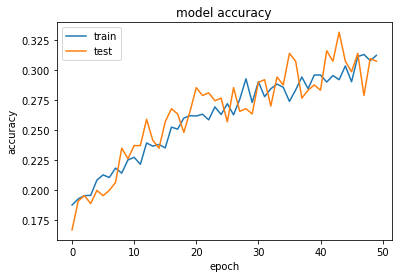

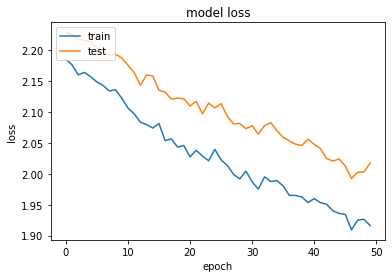

In [100]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # if not title:
    #     if normalize:
    #         title = 'Normalized confusion matrix'
    #     else:
    #         title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

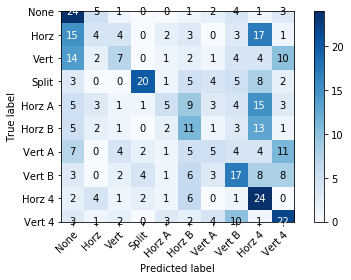

In [118]:
y_pred = model.predict([raw_test, qp_test])
y_index =np.zeros(len(y_pred))

for i in range(len(y_pred)):
    y_index[i] = np.argmax(y_pred[i])

y_test = y_test.astype(int)
y_index = y_index.astype(int)

class_names = ["None", "Horz", "Vert", "Split", "Horz A", "Horz B", "Vert A", "Vert B", "Horz 4", "Vert 4"]

plot_confusion_matrix(y_test, y_index, classes=class_names)
